# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss

### 1b. Load the data
Call the variable `cigData`. 

In [2]:
cigData = pd.read_csv('CowboyCigsData.csv', usecols=['Time', '#CigSales'], parse_dates=['Time'], index_col='Time')

In [3]:
# Normalize the data by subtracting 1,000,000 and scaling by 100,000
cigData = (cigData - 1000000) * 100000

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [4]:
cigData.head()

,#CigSales
Time,
1949-01-01,11200000
1949-02-01,11800000
1949-03-01,13200000
1949-04-01,12900000
1949-05-01,12100000


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

In [5]:
# Display basic statistics
cigData.describe()

,#CigSales
count,1.440000e+02
mean,2.802986e+07
std,1.199663e+07
min,1.040000e+07
25%,1.800000e+07
50%,2.655000e+07
75%,3.605000e+07
max,6.220000e+07


In [6]:
# Display the date range
print(f"Date range: {cigData.index.min()} to {cigData.index.max()}")

Date range: 1949-01-01 00:00:00 to 1960-12-01 00:00:00


In [7]:
# Check data frequency
print(f"Data frequency: {pd.infer_freq(cigData.index)}")

Data frequency: MS


<div class="alert alert-block alert-info">
`Data frequency: MS` means our data is being sampled on a monthly basis, at the start of each month.
</div>

Check out the columns feature of the data. How many columns are there? 

In [8]:
cigData.columns

Index(['#CigSales'], dtype='object')

Let's check out the data types of our columns.

In [9]:
cigData.dtypes

#CigSales    int64
dtype: object

Check whether there are any null values. 

In [10]:
cigData.isnull().values.any()

False

In [11]:
# Check for missing dates using Month Start frequency
date_range = pd.date_range(start=cigData.index.min(), end=cigData.index.max(), freq='MS')
missing_dates = set(date_range) - set(cigData.index)
if missing_dates:
    print("Missing dates:", missing_dates)

# Print number of rows to verify we have all months
print(f"Number of months in date range: {len(cigData)}")
print(f"Expected number of months: {len(pd.date_range(cigData.index.min(), cigData.index.max(), freq='MS'))}")

Number of months in date range: 144
Expected number of months: 144


There are no missing dates.

## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [12]:
# See data import - already done

### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [13]:
cigData.index.name = 'Month'

Call a head() to check this has worked. 

In [14]:
cigData.head()

,#CigSales
Month,
1949-01-01,11200000
1949-02-01,11800000
1949-03-01,13200000
1949-04-01,12900000
1949-05-01,12100000


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [15]:
# This was done in the import
cigData.head()

,#CigSales
Month,
1949-01-01,11200000
1949-02-01,11800000
1949-03-01,13200000
1949-04-01,12900000
1949-05-01,12100000


Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column. 

In [16]:
y = cigData['#CigSales']

Check the type of our new variable. 

In [17]:
type(y)

pandas.core.series.Series

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [18]:
y.describe()

count    1.440000e+02
mean     2.802986e+07
std      1.199663e+07
min      1.040000e+07
25%      1.800000e+07
50%      2.655000e+07
75%      3.605000e+07
max      6.220000e+07
Name: #CigSales, dtype: float64

Try visualizing the data. A simple `matplotlib` plot should do the trick.  

In [19]:
# Add year-over-year growth
yearly_sales = y.resample('Y').mean()
yoy_growth = yearly_sales.pct_change() * 100

print("\nYearly Growth Rates:")
print(yoy_growth)

# Add seasonal analysis
monthly_avg = y.groupby(y.index.month).mean()
print("\nAverage Sales by Month:")
print(monthly_avg)


Yearly Growth Rates:
Month
1949-12-31          NaN
1950-12-31    10.263158
1951-12-31    21.837709
1952-12-31    15.768854
1953-12-31    14.213198
1954-12-31     6.185185
1955-12-31    18.869899
1956-12-31    15.580986
1957-12-31    12.236608
1958-12-31     3.415517
1959-12-31    12.423447
1960-12-31    11.167315
Freq: YE-DEC, Name: #CigSales, dtype: float64

Average Sales by Month:
Month
1     2.417500e+07
2     2.350000e+07
3     2.701667e+07
4     2.670833e+07
5     2.718333e+07
6     3.116667e+07
7     3.513333e+07
8     3.510833e+07
9     3.024167e+07
10    2.665833e+07
11    2.328333e+07
12    2.618333e+07
Name: #CigSales, dtype: float64


### 2f. Plotting `y`

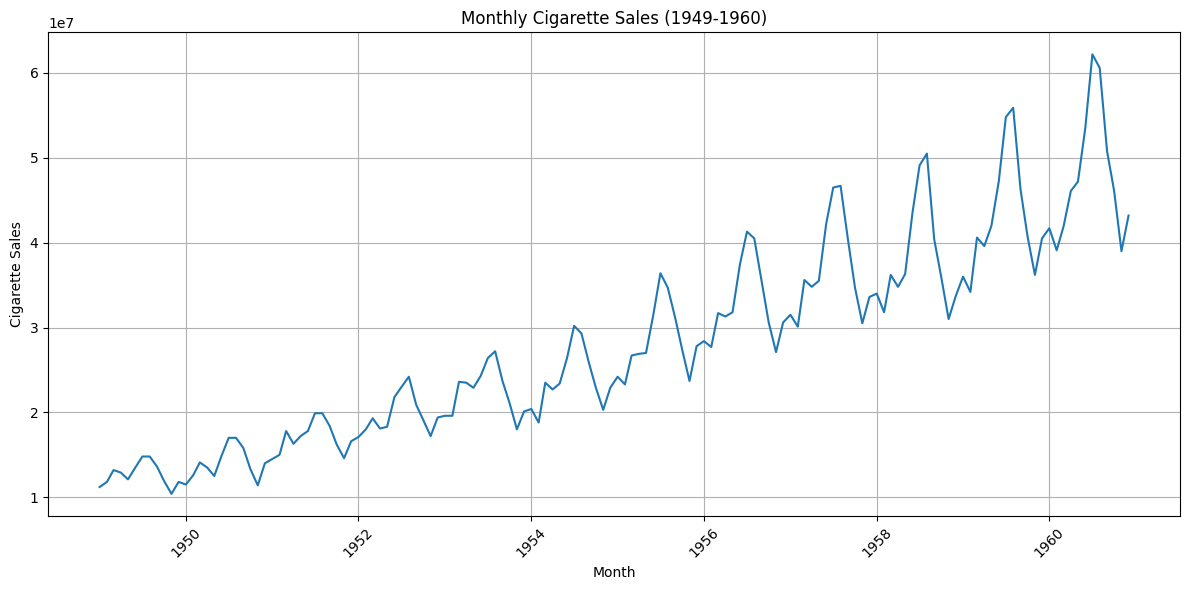

In [20]:
plt.figure(figsize=(12, 6))  # Make the plot wider for better visibility
plt.plot(y.index, y)
plt.xlabel('Month')
plt.ylabel('Cigarette Sales')
plt.title('Monthly Cigarette Sales (1949-1960)')
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.grid(True)  # Add grid for easier reading
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

<div class="alert alert-block alert-success">
<b>Response:</b><br> The number of cigarette sales is generally increasing with time. This graph also exhibits seasonality, with the year's highest number of sales and lowest number of sales happening at the same time each year. Additionally, the difference between the year's highest number of sales and lowest number of sales seems to grow larger each year.
</div>

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

-------------------------------

<div class="alert alert-block alert-success">
<b>Response:</b><br> Based on the plot we created above, our model appears to be multiplicative in nature. The seasonal changes exhibited over time appear to be increasing exponentially rather than linearly.
</div>

---
All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

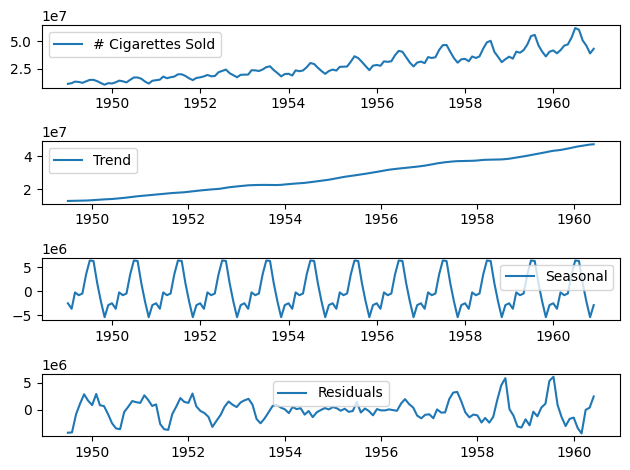

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(y)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the original data, the trend, the seasonality, and the residuals 
plt.subplot(411)
plt.plot(y, label = '# Cigarettes Sold')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [22]:
statistic, p_value, n_lags, critical_values = kpss(cigData, nlags='auto')

print('Statistic: ', statistic)
print('p-value: ', p_value)
print('Number of Lags: ', n_lags)
print('Critical Values: ', critical_values)

Statistic:  1.6513122354165233
p-value:  0.01
Number of Lags:  8
Critical Values:  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\snail\AppData\Local\Temp\ipykernel_26212\593272942.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  statistic, p_value, n_lags, critical_values = kpss(cigData, nlags='auto')


Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

### 3c. Making the data stationary 
Let's recall what it looks like. 

<Axes: xlabel='Month'>

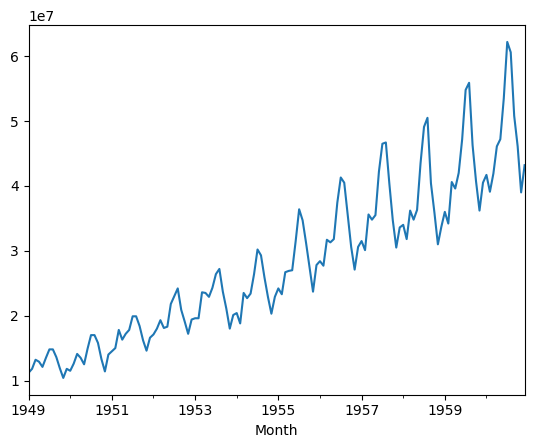

In [23]:
y.plot()

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One ofte  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

In [24]:
dflog = np.log(cigData)


When you plot this, you can see how the variance in our data now remains contant over time.

In [29]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import datetime as dt


# utility - polynomial regression
def get_polyregr_pred (df: pd.DataFrame, degree=1, retmodel=False) -> np.ndarray:
    """Return an array of Polynomial regression predictions from a DataFrame
    Alternatively, if retmodel==True, return the entire model
    
    Keyword Arguments:
    df -- A DataFrame with 'Month' and '#CigSales' columns, holding datetime objects and integer prices
    degree -- the degree of the polynomial.  (reminder that degree 1 will return straight linear regressor)
    """
    # @TODO: Assert 'Month' and '#CigSales' columns with datetime and float elements - throw TypeError
    
    # format the data into ndarrays
    df2 = df.reset_index()
    x_arr = df2.Month.map(dt.datetime.toordinal).values.reshape(-1,1)
    y_arr = df2['#CigSales'].values.reshape(-1,1)
    
    # build a polynomial regression pipeline
    polyreg = make_pipeline( PolynomialFeatures(degree),
                             LinearRegression() )
    
    # fit the model to our data
    polyreg.fit(x_arr, y_arr) 
    
    if retmodel == True:
        return polyreg
    
    return polyreg.predict(x_arr)

In [30]:
# Reset index and specify column name for datetime
df_reset = cigData.reset_index()
ord_months = df_reset['Month'].map(dt.datetime.toordinal).values.reshape(-1,1)

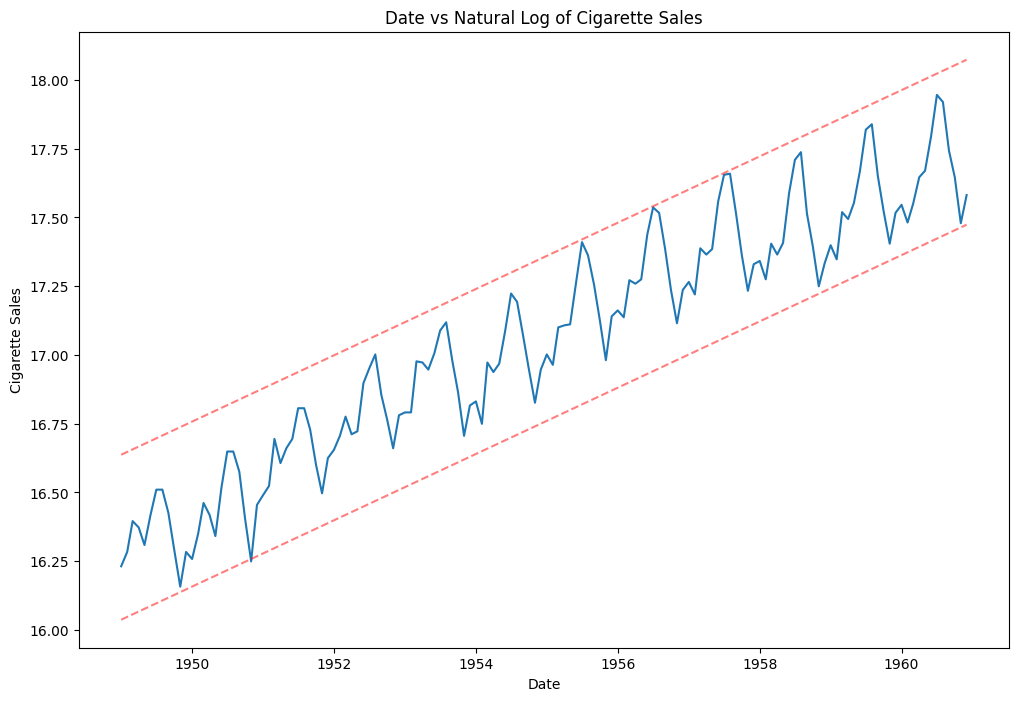

In [31]:
# get a linear regression line to visualize decreased variance in the data
# from year to year
pred = get_polyregr_pred(dflog)

plt.figure(figsize=(12,8))

plt.title('Date vs Natural Log of Cigarette Sales')
plt.plot(dflog)

# use the regression lines to bound the extremities of the data along the y axis
plt.plot(cigData.reset_index().Month, pred+.3, color='red', alpha=.5, ls='--')
plt.plot(cigData.reset_index().Month, pred-.3, color='red', alpha=.5, ls='--')

plt.xlabel('Date')
plt.ylabel('Cigarette Sales')

plt.show()

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

In [32]:
kpss(dflog.diff().dropna())

C:\Users\snail\AppData\Local\Temp\ipykernel_26212\857176892.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss(dflog.diff().dropna())


(0.03830446954674067,
 0.1,
 6,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

In [35]:
from statsmodels.tsa.arima.model import ARIMA  # Note the different import path
from sklearn.metrics import mean_squared_error
import numpy as np

#### 3di. Make a function to find the MSE of a single ARIMA model
Things get intricate here. Don't worry if you can't do this yourself and need to drop down a Tier. 

In [55]:
def evaluate_arima_model(data, arima_order):
    # Split the data
    split = int(len(data) * 0.8)
    train, test = data[0:split], data[split:len(data)]
    
    try:
        # Fit model without maxiter parameter
        model = ARIMA(train, order=arima_order)
        model_fit = model.fit()  # Remove the maxiter parameter
        
        # Make predictions
        predictions = model_fit.forecast(steps=len(test))
        
        # Calculate error
        mse = mean_squared_error(test, predictions)
        return mse
    except Exception as e:
        print(f"Failed to evaluate ARIMA{arima_order}: {str(e)}")
        return float('inf')

#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [56]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    successful_models = []
    
    print("Starting model evaluation...")
    print(f"Testing p values: {list(p_values)}")
    print(f"Testing d values: {list(d_values)}")
    print(f"Testing q values: {list(q_values)}")
    
    # Convert DataFrame to Series if necessary
    if isinstance(dataset, pd.DataFrame):
        dataset = dataset['#CigSales']
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                mse = evaluate_arima_model(dataset, order)
                if mse < best_score and mse != float('inf'):
                    best_score, best_cfg = mse, order
                    successful_models.append((order, mse))
                print(f'ARIMA{order} MSE: {mse:.3f}')
    
    if len(successful_models) > 0:
        # Sort successful models by MSE
        successful_models.sort(key=lambda x: x[1])
        print("\nTop 5 models:")
        for order, mse in successful_models[:5]:
            print(f'ARIMA{order} MSE: {mse:.3f}')
        print(f'\nBest ARIMA{best_cfg} MSE={best_score:.3f}')
    else:
        print("No successful models were fitted.")
    
    return best_cfg

In [59]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!

# Set the frequency explicitly
dflog = dflog.asfreq('MS')  # MS for Month Start frequency

# Now, we choose a couple of values to try for each parameter.
p_values = range(0, 3)
d_values = range(0, 2)  # Reduced range
q_values = range(0, 3)

# Make sure data is properly prepared
dflog = dflog.asfreq('MS')
dflog = dflog.dropna()  # Remove any NaN values

best_order = evaluate_models(dflog, p_values, d_values, q_values)

Starting model evaluation...
Testing p values: [0, 1, 2]
Testing d values: [0, 1]
Testing q values: [0, 1, 2]
ARIMA(0, 0, 0) MSE: 0.471
ARIMA(0, 0, 1) MSE: 0.453
ARIMA(0, 0, 2) MSE: 0.447
ARIMA(0, 1, 0) MSE: 0.045
ARIMA(0, 1, 1) MSE: 0.051
ARIMA(0, 1, 2) MSE: 0.035
ARIMA(1, 0, 0) MSE: 0.062
ARIMA(1, 0, 1) MSE: 0.112
ARIMA(1, 0, 2) MSE: 0.059
ARIMA(1, 1, 0) MSE: 0.053
ARIMA(1, 1, 1) MSE: 0.048
ARIMA(1, 1, 2) MSE: 0.033
ARIMA(2, 0, 0) MSE: 0.102
ARIMA(2, 0, 1) MSE: 0.080
ARIMA(2, 0, 2) MSE: 0.082
ARIMA(2, 1, 0) MSE: 0.039
ARIMA(2, 1, 1) MSE: 0.033
ARIMA(2, 1, 2) MSE: 0.033

Top 5 models:
ARIMA(2, 1, 1) MSE: 0.033
ARIMA(1, 1, 2) MSE: 0.033
ARIMA(0, 1, 2) MSE: 0.035
ARIMA(0, 1, 0) MSE: 0.045
ARIMA(0, 0, 2) MSE: 0.447

Best ARIMA(2, 1, 1) MSE=0.033


So the best p,d, q, parameters for our ARIMA model are 2, 1, 1 respectively. Now we know this, we can build the model.

<div class="alert alert-block alert-warning">
<b>ARIMA model was giving convergence errors.</b> We are using the SARIMA model with simplified parameters instead.
</div>

In [68]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA model
sarima_model = SARIMAX(dflog,
                      order=(1, 1, 1),
                      seasonal_order=(1, 1, 1, 12))
sarima_results = sarima_model.fit()

We can take a look at a summary of the model this library has built around our data.

In [69]:
print("\nSARIMA Model Summary:")
print(sarima_results.summary())


SARIMA Model Summary:
                                     SARIMAX Results                                      
Dep. Variable:                          #CigSales   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 245.152
Date:                            Mon, 18 Nov 2024   AIC                           -480.304
Time:                                    20:00:57   BIC                           -465.928
Sample:                                01-01-1949   HQIC                          -474.462
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1673      0.213      0.786      0.432      -0.250       0.584
ma.L1       

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

Text(0.5, 1.0, 'Residuals Over Time')

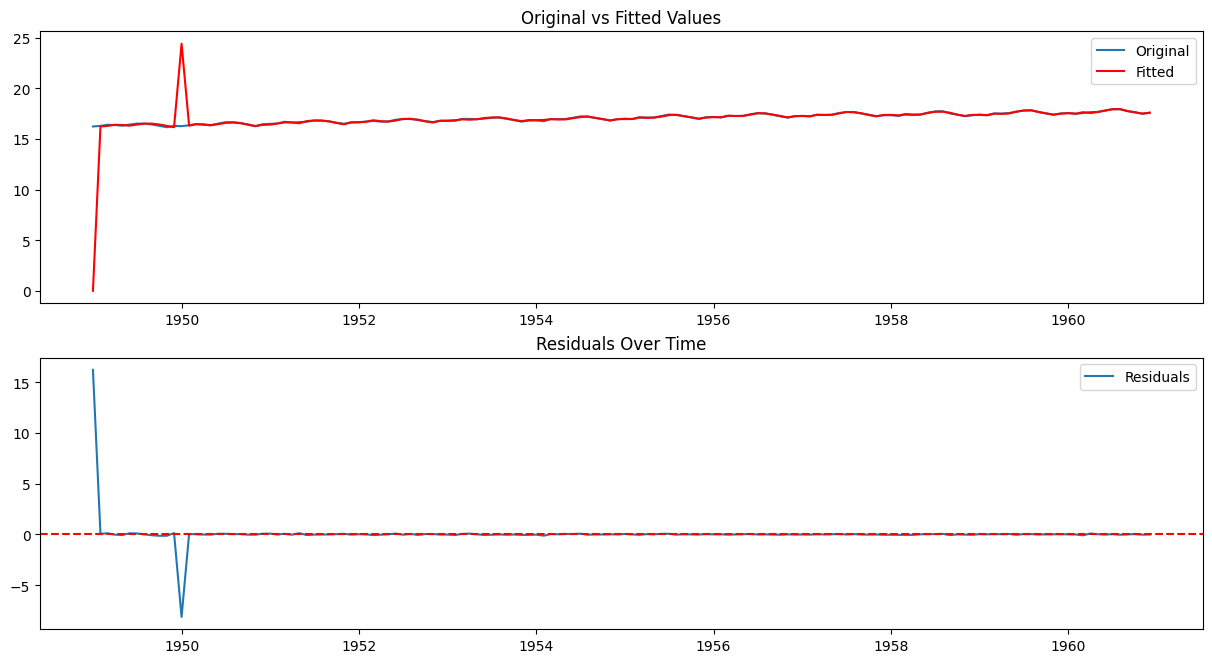

In [71]:
# Create diagnostic plots
fig = plt.figure(figsize=(15, 12))

# 1. Original vs Fitted Values
plt.subplot(311)
plt.plot(dflog.index, dflog, label='Original')
plt.plot(dflog.index, sarima_results.fittedvalues, label='Fitted', color='red')
plt.legend()
plt.title('Original vs Fitted Values')

# 2. Residuals Over Time
plt.subplot(312)
plt.plot(dflog.index, sarima_results.resid, label='Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.legend()
plt.title('Residuals Over Time')

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

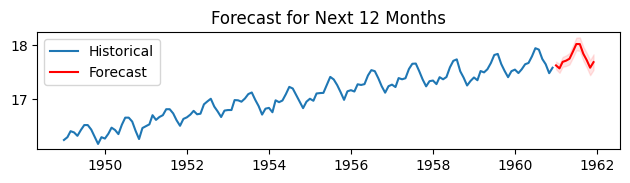


Forecast for next 12 months:
1961-01-01    17.624609
1961-02-01    17.568732
1961-03-01    17.690838
1961-04-01    17.713406
1961-05-01    17.749163
1961-06-01    17.885298
1961-07-01    18.024399
1961-08-01    18.022732
1961-09-01    17.841969
1961-10-01    17.725222
1961-11-01    17.581679
1961-12-01    17.685850
Freq: MS, Name: predicted_mean, dtype: float64


In [72]:
forecast_period = 12  # One year forecast
forecast = sarima_results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.subplot(313)
plt.plot(dflog.index, dflog, label='Historical')
plt.plot(forecast_mean.index, forecast_mean, color='red', label='Forecast')
plt.fill_between(forecast_ci.index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], 
                 color='r', alpha=0.1)
plt.legend()
plt.title('Forecast for Next 12 Months')

plt.tight_layout()
plt.show()

# Print forecast values
print("\nForecast for next 12 months:")
print(forecast_mean)

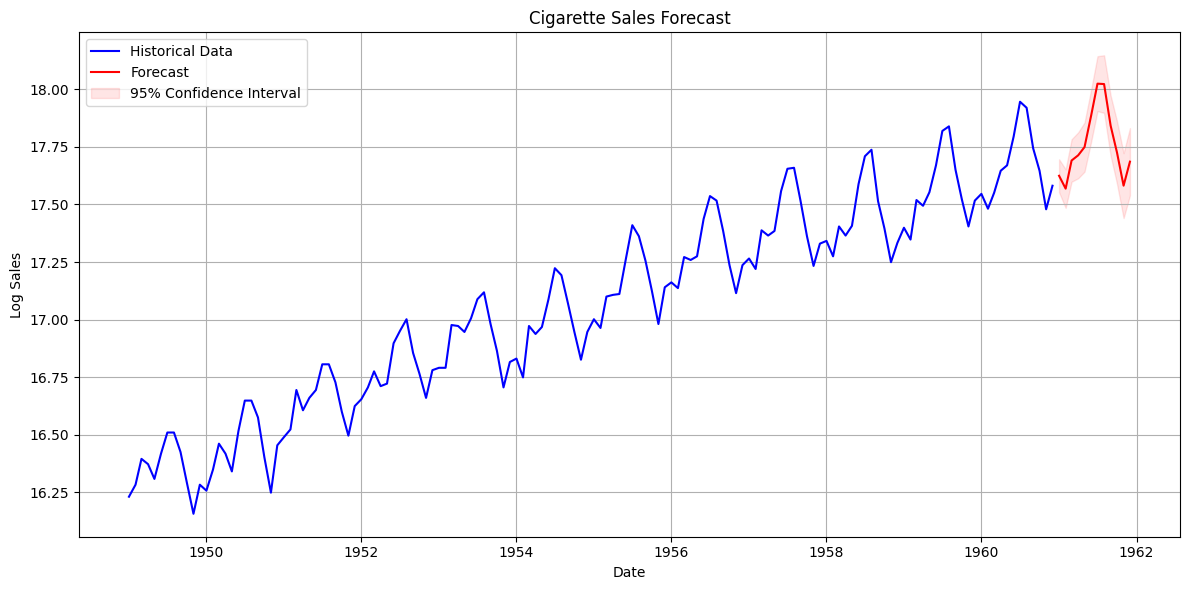


Forecasted Values:
1961-01-01    17.625
1961-02-01    17.569
1961-03-01    17.691
1961-04-01    17.713
1961-05-01    17.749
1961-06-01    17.885
1961-07-01    18.024
1961-08-01    18.023
1961-09-01    17.842
1961-10-01    17.725
1961-11-01    17.582
1961-12-01    17.686
Freq: MS, Name: Forecast, dtype: float64


In [73]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period = 12  # Forecasting one year ahead
future_dates = pd.date_range(start=dflog.index[-1], periods=forecast_period + 1, freq='MS')[1:]
# Note: [1:] removes the last date of the original data to avoid overlap

# Convert that range into a dataframe that includes your predictions
forecast = sarima_results.get_forecast(steps=forecast_period)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Create a DataFrame with the forecasted values
forecast_df = pd.DataFrame({
    'Forecast': forecast_mean,
    'Lower CI': forecast_ci.iloc[:, 0],
    'Upper CI': forecast_ci.iloc[:, 1]
}, index=future_dates)

# Plot your future predictions
plt.figure(figsize=(12, 6))
plt.plot(dflog.index, dflog, label='Historical Data', color='blue')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
plt.fill_between(forecast_df.index, 
                 forecast_df['Lower CI'], 
                 forecast_df['Upper CI'],
                 color='red', alpha=0.1, label='95% Confidence Interval')
plt.title('Cigarette Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Log Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the forecasted values
print("\nForecasted Values:")
print(forecast_df['Forecast'].round(3))

## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 